In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow
from PIL import Image

import numpy as np
import math

import tensorflow as tf
import keras
from keras.models import Sequential, Model  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2DTranspose, Reshape, Activation, Input, UpSampling2D, BatchNormalization
from keras.optimizers import Adam, Adadelta, rmsprop, SGD
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle


Using TensorFlow backend.


shape of image: (48, 48, 3)
X shape: (6912,)


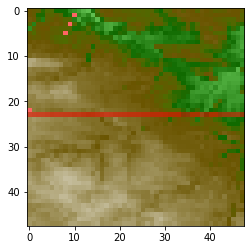

In [53]:
img = Image.open('C:\\Users\\T0241175\\Desktop\\image\\imageapplication.png')  # this is a PIL image
img = img.convert(mode='RGB')
img = img.resize((48,48))
X = img_to_array(img)/255  # this is a Numpy array + normalization
X=np.array(X)
print("shape of image: "  + str(X.shape))

imshow(array_to_img(X))

X=X.flatten()
print("X shape: " + str(X.shape))

In [3]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],))
        
      
    return parameters

In [9]:
def linear_forward(X, W1, b1, W2, b2):
    
    I = np.dot(W1,X) #hidden layer
    H=I
    H[H<0] = 0 #relu 
    Z =np.dot(W2,H) + b2 #output layer
    Y=Z
    Y[Y<0] = 0 #relu
     
    return I, H, Z, Y

In [54]:
def backpropagation(X, W1, b1, W2, b2, H, I, Z, Y, y_true):
    dW1=np.zeros((512,6912))
    db1=np.zeros((512,))
    dW2=np.zeros((16,512))
    db2=np.zeros((16,))
    dC=np.zeros((512,))
    
    for i in range(16):        
        for j in range(512):
            if(Z[i]>=0):
                dW2[i][j]=H[j]*1*(2*(Y[i]-y_true[i]))
            else:
                dW2[i][j]=0
                
    for i in range(16):
        if(Z[i]>=0):
            db2[i]=1*1*(2*(Y[i]-y_true[i]))
        else:
            db2[i]=0
    
    for i in range(512):
        for k in range(16):
            if(Z[k]>=0):
                dC[i]=dC[i]+W2[k][i]*1*(2*(Y[k]-y_true[k]))
            else:
                dC[i]=dC[i]+0
                
    for i in range(512):
        for j in range(6912):
            if(I[i]>=0):
                dW1[i][j]=X[j]*1*dC[i]
            else:
                dW1[i][j]=0

    for i in range(512):
        if(I[i]>=0):
            db1[i]=1*1*dC[i]
        else:
            db1[i]=0
    
    return db1, dW1, db2 , dW2

In [55]:
def update_parameters(b1, b2, W1, W2, db1, dW1, db2 , dW2, learning_rate):
    b1-= learning_rate*db1
    b2-= learning_rate*db2
    W1-= learning_rate*dW1
    W2-= learning_rate*dW2
    
    return b1, b2, W1, W2 

In [ ]:
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.01           # exponential decay rate for exploration prob

In [1]:
def choix_action(decay_step, explore_start, explore_stop):
    
    exp_exp_tradeoff = np.random.rand()

    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    if explore_probability>exp_exp_tradeoff:
        action=np.random.randint(16)
    else:
        action_centre=np.argmax(Y)

        if  action_centre==0:
            pas=np.random.randint(2)
            if pas==0:
                action=action_centre+1
            else:
                action=action_centre+4

        if  action_centre==3:
            pas=np.random.randint(2)
            if pas==0:
                action=action_centre-1
            else:
                action=action_centre+4

        if  action_centre==12:
            pas=np.random.randint(2)
            if pas==0:
                action=action_centre+1
            else:
                action=action_centre-4

        if  action_centre==15:
            pas=np.random.randint(2)
            if pas==0:
                action=action_centre-1
            else:
                action=action_centre-4

        if  action_centre==4 or action_centre== 8:
            pas=np.random.randint(3)
            if pas==0:
                action=action_centre+1
            if pas==1:
                action=action_centre-4
            else:
                action=action_centre+4

        if  action_centre==7 or action_centre==11:
            pas=np.random.randint(3)
            if pas==0:
                action=action_centre-1
            if pas==1:
                action=action_centre-4
            else:
                action=action_centre+4 

        if  action_centre==1 or action_centre== 2:
            pas=np.random.randint(3)
            if pas==0:
                action=action_centre-1
            if pas==1:
                action=action_centre+1
            else:
                action=action_centre+4 

        if  action_centre==13 or action_centre== 14:
            pas=np.random.randint(3)
            if pas==0:
                action=action_centre-1
            if pas==1:
                action=action_centre+1
            else:
                action=action_centre-4 
        else:
            pas=np.random.randint(4)
            if pas==0:
                action=action_centre-1
            if pas==1:
                action=action_centre+1
            if pas==2:
                action=action_centre-4 
            else:
                action=action_centre+4
    decay_step+=1
    
    return action, decay_step, explore_probability

<font color='red'>I) Initialisation des paramètres</font>

In [296]:
parameters = initialize_parameters_deep([6912,512,16])
W1=parameters["W1"]
W2=parameters["W2"]
b1=parameters["b1"]
b2=parameters["b2"]

decay_step=0

<font color='red'>II) Premier Forward pass</font>

In [297]:
I, H, Z, Y = linear_forward(X, W1, b1, W2, b2)
print(Y)

[0.0153075  0.13728852 0.06627249 0.04613827 0.         0.03642126
 0.01226758 0.14663252 0.05057017 0.01015301 0.         0.00465984
 0.09269618 0.09330825 0.02833448 0.        ]


<font color='red'>III) Choix de l'action en tenant compte du compromis exploration/exploitation</font>

In [298]:
action, decay_step, explore_probability= choix_action(decay_step, explore_start, explore_stop)
print(action)
print(decay_step)
print(explore_probability)

13
1
1.0


<font color='red'>IV) Création de notre true label en fonction de la reward obtenue après avoir effectué l'action précédente</font>

In [300]:
reward=8  #A compléter à chaque fois, reward=score*10

In [301]:
y_true=np.copy(Y)
y_true[action]=reward #on modifie la Q value de l'action correspondante uniquement
print(y_true)

[1.53074973e-02 1.37288523e-01 6.62724876e-02 4.61382665e-02
 0.00000000e+00 3.64212575e-02 1.22675775e-02 1.46632515e-01
 5.05701693e-02 1.01530100e-02 0.00000000e+00 4.65983551e-03
 9.26961816e-02 8.00000000e+00 2.83344788e-02 0.00000000e+00]


<font color='red'>V) Backward pass : backpropagation (calcul de gradients) et mise à jour des paramètres</font>

In [302]:
for i in range(5):
    
    db1, dW1, db2 , dW2= backpropagation(X, W1, b1, W2, b2, H, I, Z, Y, y_true)

    b1, b2, W1, W2 = update_parameters(b1, b2, W1, W2, db1, dW1, db2 , dW2, 0.001)  #0.005
    
    I, H, Z, Y = linear_forward(X, W1, b1, W2, b2)

<font color='red'>VI) Enfin on refait un forward pass pour voir si le vecteur de sortie a bien été modifié comme on le souhaitait.</font>

In [303]:
I, H, Z, Y = linear_forward(X, W1, b1, W2, b2)
print(Y)

[0.00000000e+00 1.97105795e-01 8.76136727e-02 5.31179211e-02
 0.00000000e+00 6.10816027e-02 4.74152445e-02 2.30659055e-01
 6.43099125e-02 1.14806517e-02 0.00000000e+00 3.17164462e-03
 1.36645313e-01 8.00186944e+00 6.12287427e-02 0.00000000e+00]


<font color='red'>VII) On répète l'opération à partir de III)</font>